# **Jumanji's Snake with Anakin**

This notebook plugs in the Jumanji Snake environment to an Online Deep-Q learning agent following the [Anakin](https://arxiv.org/abs/2104.06272) design. We use the [Podracer Architectures for Scalable RL](https://colab.research.google.com/drive/1974D-qP17fd5mLxy6QZv-ic4yxlPJp-G?usp=sharing) colab by Matteo Hessel, Manuel Kroiss, Fabio Viola, Hado van Hasselt as a basis - most of the code below is copied verbatim with a few small adjustments. 


## Imports

In [ ]:
! pip install -U pip
! pip install jumanji
# Install additional dependencies
! pip install rlax -q
! pip install dm_haiku -q
! pip install optax -q
! pip install tqdm -q

print("For the install to work, please restart the notebook if instructed to.")

In [1]:
# Imports
import jax
import warnings
accelerator_type = jax.devices()[0].platform
if accelerator_type == 'tpu':
    # Setup TPU
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print("Running with TPU!")
elif accelerator_type == "gpu":
    print("Running with GPU!")
else:
    print("Running with CPU!")
    warnings.warn("Running with CPU. We reccomend running this notebook in Colab with TPU enabled,"
              "or GPU if TPU is not available.")

print(f"Devices: {jax.devices()}")
import chex
import jax
import haiku as hk
from jax import lax
from jax import random
from jax import numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import rc
import optax
import rlax
import timeit
from tqdm import tqdm

# Jumanji imports
from jumanji import Environment
import jumanji
from jumanji.wrappers import AutoResetWrapper

Running with GPU!
Devices: [GpuDevice(id=0, process_index=0)]


/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [2]:
# Class for timing blocks of code.
class TimeIt():
    def __init__(self, tag, frames=None):
        self.tag = tag
        self.frames = frames

    def __enter__(self):
      self.start = timeit.default_timer()
      return self

    def __exit__(self, *args):
        self.elapsed_secs = timeit.default_timer() - self.start
        msg = self.tag + (': Elapsed time=%.2fs' % self.elapsed_secs)
        if self.frames:
            msg += ', FPS=%.2e' % (self.frames / self.elapsed_secs)
            print(msg)

## Anakin
We follow the code from the [Podracer Architectures for Scalable RL](https://colab.research.google.com/drive/1974D-qP17fd5mLxy6QZv-ic4yxlPJp-G?usp=sharing) colab with the folowing additions:


*   Epsilon greedy action selection (instead of greedy action selection).
*   We record metrics from interation with the environment, such as the mean and max episode return across each batch. 


### Define key containers

In [3]:
@chex.dataclass(frozen=True)
class TimeStep:
    """Data used for training."""

    q_values: chex.Array
    action: chex.Array
    discount: chex.Array
    reward: chex.Array


@chex.dataclass(frozen=True)
class EpisodeMetrics:
    """Metrics that we use to keep track of the episode return and length 
    throughout interation with the environment."""

    episode_return: chex.Array
    episode_length: chex.Array

### Define the Deep-Q network

In [4]:
def get_network_fn(num_outputs: int,
                   mlp_units = (64, 64),
                   conv_n_channels=8):
    """Define conv net for agent."""

    def network_fn(obs: chex.Array) -> chex.Array:
        return hk.Sequential(
            [
                hk.Conv2D(conv_n_channels, (2, 2), 2),
                jax.nn.relu,
                hk.Conv2D(conv_n_channels, (2, 2), 1),
                jax.nn.relu,
                hk.Flatten(),
                hk.nets.MLP((*mlp_units, num_outputs), activate_final=False)
            ]
        )(obs)
    return hk.without_apply_rng(hk.transform(network_fn))

### Define the learner function
This contains the following key functionality:
*   Collect experience for a single trajectory, recording any useful information.
*   Calculate the Q-learning loss for the trajectory.
*   Calculate the gradient of the loss with respect to the parameters of the network.
*   Aggregate the gradient across a batch of trajectories, and across multiple devices (if using TPU). 
*   Update the parameters of the network using the gradient.
*   Aggregate useful information (such as the episode return) for visualising training.
*   Run multiple updates to the agent parameters without going back to python using `jax.lax.scan`. The original Anakin implementation uses `jax.lax.fori` for this. However as we would like to obtain information from each step of the algoirthm for visualisation of training we use `jax.lax.scan`. 

In [5]:
def get_learner_fn(
    env,
    forward_pass,
    opt_update,
    rollout_len,
    agent_discount,
    lambda_,
    iterations,
    epsilon,
):
    """Define the minimal unit of computation in Anakin."""

    def loss_fn(params, outer_rng, env_state, prev_obs, episode_metrics):
        """Compute the loss on a single trajectory."""

        def step_fn(carry, rng):
            env_state, prev_obs, episode_metrics = carry
            q_values = forward_pass(params, prev_obs[None,])[
                0
            ]  # forward pass.
            action = rlax.epsilon_greedy(epsilon).sample(rng, q_values)
            env_state, env_timestep = env.step(
                env_state, action
            )  # step environment.

            obs = env_timestep.observation
            discount = env_timestep.discount
            reward = env_timestep.reward
            # record info that we will log
            info = {
                "episode_return": jnp.where(
                    discount == 0.0, reward + episode_metrics.episode_return, jnp.nan
                ),
                "episode_length": jnp.where(
                    discount == 0.0, 1 + episode_metrics.episode_length, jnp.nan
                ),
            }
            # update the episode_metrics that we use to keep track of the 
            # episode return and length.
            episode_metrics = EpisodeMetrics(
                episode_return=jnp.where(
                    discount == 0.0,
                    jnp.array(0.0),
                    reward + episode_metrics.episode_return,
                ),
                episode_length=jnp.where(
                    discount == 0.0, jnp.array(0), 1 + episode_metrics.episode_length
                ),
            )
            carry = env_state, obs, episode_metrics
            # Note this differes from the TimeStep in the original Anakin notebook, as
            # the discount and reward are for AFTER the action was taken.
            return carry, (
                TimeStep(  # return env state and transition data.
                    q_values=q_values,
                    action=action,
                    discount=discount,
                    reward=reward,
                ),
                info,
            )

        step_rngs = random.split(outer_rng, rollout_len)
        (env_state, prev_obs, episode_metrics), (rollout, info) = lax.scan(
            step_fn, (env_state, prev_obs, episode_metrics), step_rngs
        )  # trajectory.
        qa_tm1 = rlax.batched_index(rollout.q_values[:-1], rollout.action[:-1])
        # compute multi-step temporal diff error.
        # The discount and reward in the TimeStep come AFTER the action (see step_fn).
        # This differs to the original Anakin notebook where they were from the step BEFORE 
        # the action - hence the slicing below differs from the original Anakin notebook.
        td_error = rlax.td_lambda(  
            v_tm1=qa_tm1,  # predictions.
            r_t=rollout.reward[:-1],  # rewards.
            discount_t=agent_discount * rollout.discount[:-1],  # discount.
            v_t=jnp.max(rollout.q_values[1:], axis=-1),  # bootstrap values.
            lambda_=lambda_,
        )  # mixing hyper-parameter lambda.
        # record info for visualising training progress.
        info = {
            "episode_return": jnp.nanmean(info["episode_return"], axis=0),
            "episode_length": jnp.nanmean(info["episode_length"], axis=0),
            "reward": jnp.mean(rollout.reward),
            "q_values": jnp.mean(qa_tm1),
            "max_episode_return": jnp.nanmax(info["episode_return"], axis=0)
        }
        return jnp.mean(td_error**2), (env_state, prev_obs, episode_metrics, info)

    def update_fn(params, opt_state, rng, env_state, prev_obs, episode_metrics):
        """Compute a gradient update from a single trajectory."""
        rng, loss_rng = random.split(rng)
        grads, (
            new_env_state,
            new_prev_obs,
            episode_metrics,
            info,
        ) = jax.grad(  # compute gradient on a single trajectory.
            loss_fn, has_aux=True
        )(
            params, loss_rng, env_state, prev_obs, episode_metrics
        )
        grads = lax.pmean(grads, axis_name="j")  # reduce mean across cores.
        grads = lax.pmean(grads, axis_name="i")  # reduce mean across batch.
        updates, new_opt_state = opt_update(grads, opt_state)  # transform grads.
        new_params = optax.apply_updates(params, updates)  # update parameters.
        return (
            new_params,
            new_opt_state,
            rng,
            new_env_state,
            new_prev_obs,
            episode_metrics,
            info,
        )

    def learner_fn(params, opt_state, rngs, env_states, prev_obses, episode_metrics):
        """Vectorise and repeat the update."""
        batched_update_fn = jax.vmap(
            update_fn, axis_name="j"
        )  # vectorize across batch.

        def iterate_fn(carry, _):  # repeat many times to avoid going back to Python.
            params, opt_state, rngs, env_states, prev_obses, episode_return = carry
            (
                new_params,
                new_opt_state,
                rng,
                new_env_state,
                new_prev_obs,
                episode_return,
                info,
            ) = batched_update_fn(
                params, opt_state, rngs, env_states, prev_obses, episode_return
            )
            carry = (
                new_params,
                new_opt_state,
                rng,
                new_env_state,
                new_prev_obs,
                episode_return,
            )
            # record mean of all info over the batch, as well as the max return.
            max_return_info = {"max_episode_return": 
                               jnp.nanmax(info["max_episode_return"], axis=0)}
            info = jax.tree_util.tree_map(lambda x: jnp.nanmean(x, axis=0), info)
            info.update(max_return_info)
            return carry, info

        init = params, opt_state, rngs, env_states, prev_obses, episode_metrics
        return jax.lax.scan(iterate_fn, init, xs=None, length=iterations)

    return learner_fn


### Define the experiment
Sets up a run of the agent given a set of hyper-parameters.
The experiment runs multiple pmapped iterations of the `learner_fn` until the desired total number of training iterations has been reached. 

In [6]:
def run_experiment(
    env,
    batch_size,
    rollout_len,
    step_size,
    iterations,
    seed,
    epsilon = 0.02,
    agent_discount=0.99,
    lambda_=0.95,
    inner_iter_length=100, 
    mlp_units = (64,64)
):
    """Runs experiment. 

    `inner_iter_length` sets how many iterations to do in the `jax.lax.scan`
    before going back to python
    """
    cores_count = len(jax.devices())  # get available TPU cores.
    network = get_network_fn(env.action_spec().num_values, mlp_units=mlp_units)  # define network.
    optim = optax.adam(step_size)  # define optimiser.

    rng, rng_e, rng_p = random.split(random.PRNGKey(seed), num=3)  # prng keys.
    dummy_obs = env.observation_spec().generate_value()[
        None,
    ]  # dummy for net init.
    params = network.init(rng_p, dummy_obs)  # initialise params.
    opt_state = optim.init(params)  # initialise optimiser stats.


    learn = get_learner_fn(  # get batched iterated update.
        env,
        network.apply,
        optim.update,
        rollout_len=rollout_len,
        agent_discount=agent_discount,
        lambda_=lambda_,
        iterations=inner_iter_length,
        epsilon=epsilon
    )
    learn = jax.pmap(learn, axis_name="i")  # replicate over multiple cores.

    broadcast = lambda x: jnp.broadcast_to(x, (cores_count, batch_size) + x.shape)
    params = jax.tree_map(broadcast, params)  # broadcast to cores and batch.
    opt_state = jax.tree_map(broadcast, opt_state)  # broadcast to cores and batch

    episode_metrics = EpisodeMetrics(
            episode_return=jnp.zeros(shape=(), dtype=jnp.float32),
            episode_length=jnp.zeros(shape=(), dtype=jnp.int16),
        )
    episode_metrics = jax.tree_map(broadcast, episode_metrics)

    rng, *env_rngs = jax.random.split(rng, cores_count * batch_size + 1)
    env_states, timesteps = jax.vmap(env.reset)(jnp.stack(env_rngs))  # init envs.
    rng, *step_rngs = jax.random.split(rng, cores_count * batch_size + 1)

    reshape = lambda x: jax.tree_util.tree_map(
        lambda x: x.reshape((cores_count, batch_size) + x.shape[1:]), x
    )
    step_rngs = reshape(jnp.stack(step_rngs))  # add dimension to pmap over.
    env_states = reshape(env_states)  # add dimension to pmap over.
    prev_obs = reshape(timesteps.observation)

    num_frames_compile = cores_count * inner_iter_length * rollout_len * batch_size
    with TimeIt(tag="COMPILATION", frames=num_frames_compile):
        learn(params, opt_state, step_rngs, env_states, prev_obs, episode_metrics)  # compiles

    num_frames = cores_count * iterations * rollout_len * batch_size
    n_outer_iter = int(iterations // inner_iter_length)
    with TimeIt(tag="EXECUTION", frames=num_frames):
        for i in tqdm(range(n_outer_iter)):
            (
                params,
                opt_state,
                step_rngs,
                env_states,
                prev_obs,
                episode_metrics,
            ), new_info = learn(  # runs compiled fn
                params, opt_state, step_rngs, env_states, prev_obs, 
                episode_metrics
            )
            # record metrics
            max_return_info = {"max_episode_return": 
                               jnp.nanmax(new_info["max_episode_return"], axis=0)}
            new_info = jax.tree_util.tree_map(lambda x: jnp.nanmean(x, axis=0), new_info)
            new_info.update(max_return_info)
            if i == 0:
                info = new_info
            else:
                info = {key: jnp.concatenate((info[key], new_info[key])) for key in info.keys()}
    params_single_device = jax.tree_util.tree_map(lambda x: x[0, 0], params)
    return params_single_device, info

### Run experiment and visualise results

In [7]:
print("Running on", len(jax.devices()), "cores.", flush=True)  # !expected 8!
# We auto-reset the environment state when the episode ends during training.
env = AutoResetWrapper(jumanji.make('Snake-6x6-v0'))

# Define hyper-parameters for each accelerator type.
config = {
    "tpu": { "seed": 0, "step_size": 1e-2, "iterations": 8000,  "batch_size": 256, "rollout_len": 8, "mlp_units": (64, 64),},
    "gpu": { "seed": 0, "step_size": 1e-3, "iterations": 20000, "batch_size": 256, "rollout_len": 8, "mlp_units": (64, 64),},
    "cpu": { "seed": 0, "step_size": 1e-3, "iterations": 30000, "batch_size": 32,  "rollout_len": 4, "mlp_units": (48, 48),}
}

params, info = run_experiment(env=env, **config[accelerator_type])

Running on 1 cores.


/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


COMPILATION: Elapsed time=6.42s, FPS=3.19e+04


100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


EXECUTION: Elapsed time=151.73s, FPS=2.70e+05


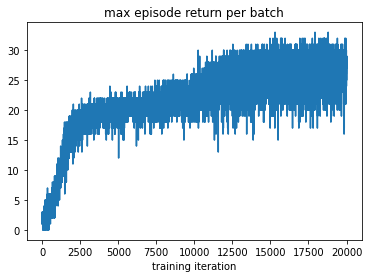

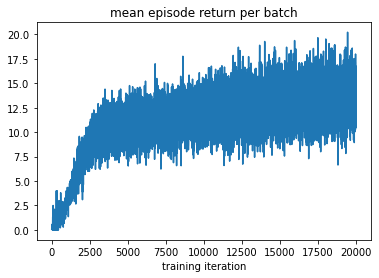

In [8]:
# Plot the mean and max return throughout training.
# The maximum return possible on Snake6-v0 is 35.
# We see that by the end of the episode the agent is regularly obtaining the strong performance.
# Some other keys in info that can also be plotted: "q_values", "reward", "episode_length"

plt.plot(info["max_episode_return"])
plt.title("max episode return per batch")
plt.xlabel("training iteration")
plt.show()

plt.plot(info["episode_return"])
plt.title("mean episode return per batch")
plt.xlabel("training iteration")
plt.show()


In [10]:
# Now we run an episode using greedy action selection while rendering the environment.
# You re-run this sell with a different random seed if you would like to see a different run.

# Re-instantiate the environment without the auto-reset.
env = jumanji.make('Snake-6x6-v0')
key = jax.random.PRNGKey(1)
network = get_network_fn(env.action_spec().num_values, mlp_units=config[accelerator_type]["mlp_units"])

episode_states = []
state, timestep = env.reset(key)
episode_return = 0
while not timestep.last():
    episode_states.append(state)
    key, subkey = jax.random.split(key)
    q_values = network.apply(params, timestep.observation[None, ])[0]  # forward pass.
    action = jnp.argmax(q_values)  # greedy policy.
    state, timestep = env.step(state, action)  # step environment
    episode_return += timestep.reward
print(f"episode complete with return of {episode_return}")

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


episode complete with return of 29.0


In [11]:
%matplotlib inline
# Visualise the episode!
# You can go back to the previous cell and change the seed if you would like to see a different run.
rc('animation', html='jshtml') 
animation = env.animation(episode_states)
animation

/usr/local/lib/python3.7/dist-packages/jumanji/environments/games/snake/env.py:494: MatplotlibDeprecationWarning: 
The modification of the Axes.patches property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del ax.patches[:]
